In [29]:
import h5py
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys
import sklearn

In [2]:

# sys.path.append('/home/da886/yolov5/')  # Replace with the actual path to the yolov5 directory

# Set device IDs for multi-GPU usage
device_ids = [0, 1, 2]
import torch
import torchvision.transforms as transforms


Data Loader

In [41]:
import h5py
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class MyDataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        # Randomly select an image if no index is provided
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]  # Only plot valid centers
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o', s=5)  # center[1] is x, center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        # Sort centers by their second and first columns (equivalent to x and y coordinates)
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        # Normalize the images and centers
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        
        # Normalize the centers by the max value
        normalized_centers = sorted_centers / np.max(sorted_centers)

        # Convert normalized centers to torch tensor and add a new dimension for midpoints
        normalized_midpoints = torch.tensor(normalized_centers).unsqueeze(1)
        
        return torch.tensor(normalized_images), normalized_midpoints

    def split_data(self, train_size=0.8, random_state=42):
        # Normalize the data
        normalized_images, normalized_midpoints = self.normalize_data()

        # Convert tensors to numpy for splitting
        normalized_images_np = normalized_images.numpy()
        normalized_midpoints_np = normalized_midpoints.numpy()

        # Split the data using train_test_split
        return train_test_split(normalized_images_np, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [42]:

# Example usage
dataset = MyDataLoader('/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_13_32by32_SparsespotsRandomIndex.h5')


In [33]:
dataset.centers.shape

(12000, 13, 3)

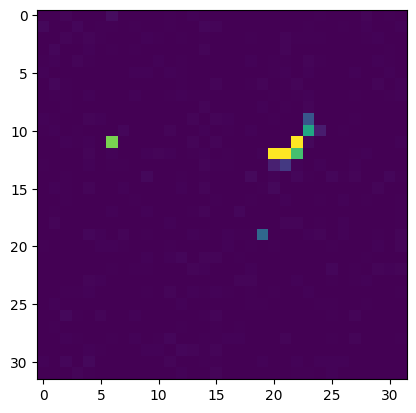

In [36]:
plt.imshow(dataset.images[1])

In [37]:
dataset.images.shape

(12000, 32, 32)

In [48]:
# from torch.utils.data import DataLoader

# Initialize the dataset and DataLoader
data_loader = MyDataLoader('/home/da886/Final Electron counting project/Images and Labels/12KFixed_Mixed_13_32by32_SparsespotsRandomIndex.h5')
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=13)


Moder Definition

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

class ModelBuilder(nn.Module):
    def __init__(self, input_shape=(1, 64, 64), num_classes=13, num_coordinates=2, learning_rate=1e-2, weights_path=None, l1_reg=0.001, l2_reg=0.01):
        super(ModelBuilder, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
        # Define the model layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 256, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # self.batchnorm = nn.BatchNorm2d(256)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes * num_coordinates) 
        self.reshape = lambda x: x.view(-1, num_classes, num_coordinates)  # Reshaping function
        
        # Define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Load weights if provided
        if weights_path is not None:
            self.load_state_dict(torch.load(weights_path))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv2(x))
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        
        x = torch.relu(self.conv7(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv8(x))
        x = self.maxpool(x)
        x = torch.relu(self.conv9(x))
        x = self.maxpool(x)
        
        x = torch.relu(self.conv10(x))
        x = self.maxpool(x)
        # x = self.batchnorm(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        x = self.reshape(x)
        
        return x
    
    def compile_model(self, loss_function):
        self.loss_function = loss_function
    
    def train_model(self, train_loader, val_loader, epochs, device):
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zero the parameter gradients
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self(inputs)
                loss = self.loss_function(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
            
            # Validation
            val_loss = 0.0
            self.eval()
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    loss = self.loss_function(outputs, labels)
                    val_loss += loss.item()

            # Logging the loss
            history['train_loss'].append(running_loss / len(train_loader))
            history['val_loss'].append(val_loss / len(val_loader))

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")
        
        return history


In [107]:
model = ModelBuilder(input_shape=(1, 32, 32), num_classes=13, num_coordinates=2)

In [49]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming `data_loader` is an instance of the `DataLoader` class you defined

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

# Convert numpy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_midpoints_tensor = torch.tensor(train_midpoints, dtype=torch.float32)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
val_midpoints_tensor = torch.tensor(val_midpoints, dtype=torch.float32)

# Create TensorDataset for training and validation sets
train_dataset = TensorDataset(train_images_tensor, train_midpoints_tensor)
val_dataset = TensorDataset(val_images_tensor, val_midpoints_tensor)

# Define PyTorch DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [78]:
train_images.shape,train_images_tensor.shape,train_midpoints.shape,train_midpoints_tensor.shape

((9600, 32, 32),
 torch.Size([9600, 32, 32]),
 (9600, 1, 13, 2),
 torch.Size([9600, 1, 13, 2]))

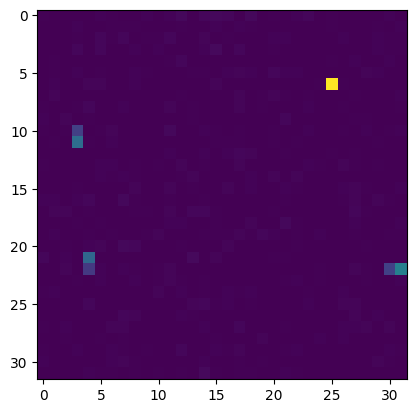

In [57]:
plt.imshow(train_images_tensor[0])

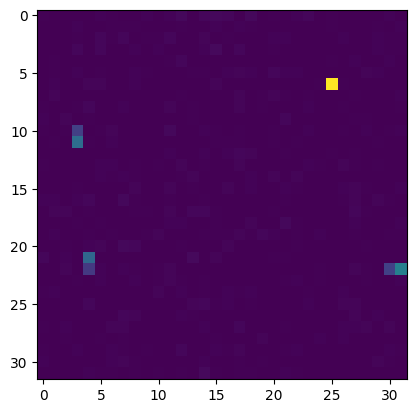

In [58]:
plt.imshow(train_images[0])

In [79]:
train_images_tensor[0].shape

torch.Size([32, 32])

In [69]:
model

ModelBuilder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=26, bias=True)
)

In [87]:
output = model(train_images_tensor.unsqueeze(1))
output.shape

torch.Size([9600, 13, 2])

In [90]:
train_midpoints_tensor.shape

torch.Size([9600, 1, 13, 2])

In [92]:
criterion = nn.MSELoss()
loss = criterion(output.unsqueeze(1), train_midpoints_tensor)
loss


tensor(0.3295, grad_fn=<MseLossBackward0>)

In [50]:
# Define the optimizer (Adam or SGD)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optionally, define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


torch.Size([16, 1, 32, 32]) torch.Size([16, 13, 3])


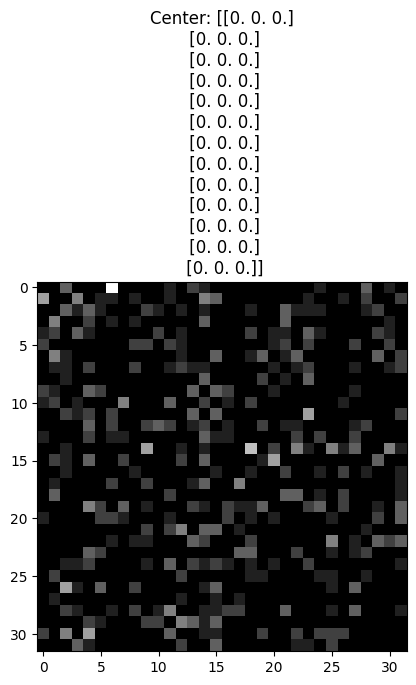

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
batch = next(iter(train_loader))
images, labels = batch
print(images.shape, labels.shape)
plt.imshow(images[0].squeeze().numpy(), cmap='gray')
plt.title('Center: {}'.format(labels[0].numpy()))
plt.show()

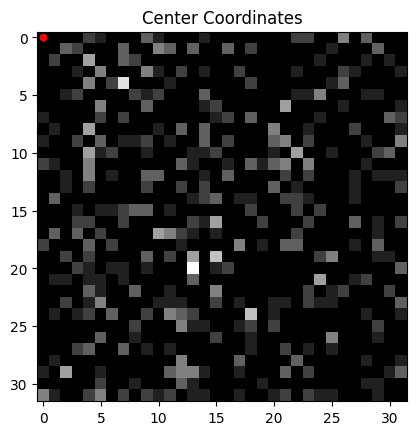

In [13]:
import matplotlib.pyplot as plt

# Get a batch from the DataLoader
batch = next(iter(train_loader))
images, labels = batch

# Display the first image in the batch
plt.imshow(images[0].squeeze().numpy(), cmap='gray')

# Extract the label information (assuming labels are in the format [class_id, x_center, y_center])
centers = labels[0].numpy()[:, 1:]  # Extract only the x_center, y_center (ignore class_id)

# Plot the center points on the image
for center in centers:
    x, y = center
    plt.scatter(x, y, color='red', s=15)  # Plot the center with red color

plt.title('Center Coordinates')
plt.show()


In [108]:
model.compile_model(nn.MSELoss())


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) 

ModelBuilder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=26, bias=True)
  (loss

In [110]:
history = model.train_model(train_loader, val_loader, 10, device)

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 32, 32, 32] to have 1 channels, but got 32 channels instead